In [1]:
import warnings

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convolutional Autoencoder

Convolutional Autoencoder Structure:

In [3]:
# Define the Convolutional Autoencoder (CAE) architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.ls = 32

        # Define separate encoders for each signal
        self.ecg_encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=20, stride=10, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, self.ls, kernel_size=10, stride=5, padding=1),
        )
        self.rsp_encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=20, stride=10, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, self.ls, kernel_size=10, stride=5, padding=1),
        )
        self.eda_tonic_encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=20, stride=10, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, self.ls, kernel_size=10, stride=5, padding=1),
        )
        self.eda_phasic_encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=20, stride=10, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, self.ls, kernel_size=10, stride=5, padding=1),
        )

        # Fully connected layer to compress the latent space
        self.fc = nn.Linear(128, self.ls)

        # Fully connected layer to decompress the latent space
        self.fc_decoded = nn.Linear(self.ls, 128)

        # Define separate decoders for each signal
        self.ecg_decoder = nn.Sequential(
            nn.ConvTranspose1d(self.ls, 8, kernel_size=10, stride=5, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=20, stride=10, padding=1, output_padding=2),
            nn.Sigmoid(),
        )
        self.rsp_decoder = nn.Sequential(
            nn.ConvTranspose1d(self.ls, 8, kernel_size=10, stride=5, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=20, stride=10, padding=1, output_padding=2),
            nn.Sigmoid(),
        )
        self.eda_tonic_decoder = nn.Sequential(
            nn.ConvTranspose1d(self.ls, 8, kernel_size=10, stride=5, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=20, stride=10, padding=1, output_padding=2),
            nn.Sigmoid(),
        )
        self.eda_phasic_decoder = nn.Sequential(
            nn.ConvTranspose1d(self.ls, 8, kernel_size=10, stride=5, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=20, stride=10, padding=1, output_padding=2),
            nn.Sigmoid(),
        )

    def encode(self, x):
        # Split input by channel for independent processing
        ecg = x[:, 0, :].unsqueeze(1)
        rsp = x[:, 1, :].unsqueeze(1)
        eda_tonic = x[:, 2, :].unsqueeze(1)
        eda_phasic = x[:, 3, :].unsqueeze(1)

        # Encode each signal independently
        print(ecg.shape)
        print(self.ecg_encoder[0](ecg).shape)
        ecg_encoded = self.ecg_encoder(ecg)
        print(ecg_encoded.shape)
        rsp_encoded = self.rsp_encoder(rsp)
        eda_tonic_encoded = self.eda_tonic_encoder(eda_tonic)
        eda_phasic_encoded = self.eda_phasic_encoder(eda_phasic)

        # Concatenate the latent representations along the last dimension
        latent_space = torch.cat(
            (ecg_encoded, rsp_encoded, eda_tonic_encoded, eda_phasic_encoded), dim=1
        )

        latent_space = latent_space.permute(0, 2, 1)

        # Compress the latent space
        latent_space = self.fc(latent_space)

        return latent_space

    def decode(self, latent_space):
        # Decompress the latent space
        latent_space = self.fc_decoded(latent_space)
        latent_space = latent_space.permute(0, 2, 1)

        # Split latent space back into separate channels
        ecg_latent, rsp_latent, eda_tonic_latent, eda_phasic_latent = torch.split(
            latent_space, self.ls, dim=1
        )
        # Decode each signal independently
        ecg_decoded = self.ecg_decoder(ecg_latent)
        rsp_decoded = self.rsp_decoder(rsp_latent)
        eda_tonic_decoded = self.eda_tonic_decoder(eda_tonic_latent)
        eda_phasic_decoded = self.eda_phasic_decoder(eda_phasic_latent)

        # Concatenate the decoded signals to form the output
        reconstructed = torch.cat(
            (ecg_decoded, rsp_decoded, eda_tonic_decoded, eda_phasic_decoded), dim=1
        )

        return reconstructed

    def forward(self, x):
        latent_space = self.encode(x)
        reconstructed = self.decode(latent_space)
        return reconstructed

In [4]:
learning_rate = 0.001

In [5]:
physiological_data = pd.read_csv("../Physiological Preprocessed/Exp2/NST01_baseline.csv", usecols=["Time", "ECG_Clean", "RSP_Clean", "EDA_Tonic", "EDA_Phasic"])
physiological_data["Time"] = pd.to_timedelta(physiological_data["Time"])
physiological_data.set_index("Time", inplace=True)
physiological_data

,ECG_Clean,RSP_Clean,EDA_Tonic,EDA_Phasic
Time,,,,
0 days 00:00:04.095000,-0.066385,-0.461210,16.345360,0.121988
0 days 00:00:04.096000,-0.065399,-0.460933,16.345334,0.121846
0 days 00:00:04.097000,-0.064423,-0.460650,16.345308,0.121701
0 days 00:00:04.098000,-0.063473,-0.460362,16.345282,0.121555
0 days 00:00:04.099000,-0.062561,-0.460069,16.345256,0.121406
...,...,...,...,...
0 days 00:05:05.316000,-0.082627,2.822491,19.347452,0.009673
0 days 00:05:05.317000,-0.081440,2.825842,19.347507,0.009577
0 days 00:05:05.318000,-0.080288,2.829178,19.347562,0.009481


In [6]:
# Normalize the data
scalar = MinMaxScaler()
data = scalar.fit_transform(physiological_data)
physiological_data = pd.DataFrame(data, columns=physiological_data.columns, index=physiological_data.index)
physiological_data

,ECG_Clean,RSP_Clean,EDA_Tonic,EDA_Phasic
Time,,,,
0 days 00:00:04.095000,0.237662,0.512428,0.124838,0.431105
0 days 00:00:04.096000,0.238469,0.512451,0.124833,0.431044
0 days 00:00:04.097000,0.239268,0.512475,0.124828,0.430981
0 days 00:00:04.098000,0.240045,0.512499,0.124822,0.430918
0 days 00:00:04.099000,0.240792,0.512524,0.124817,0.430853
...,...,...,...,...
0 days 00:05:05.316000,0.224375,0.788946,0.733791,0.382416
0 days 00:05:05.317000,0.225346,0.789228,0.733802,0.382374
0 days 00:05:05.318000,0.226289,0.789509,0.733814,0.382332


In [7]:
baseline = physiological_data.copy() # backup the original data

In [8]:
segment_size = "1s"
step_size = "0.001s"

In [9]:
# Use 12 second segments for training data
X = []
len_segment = pd.Timedelta(segment_size) / pd.Timedelta(step_size)
while len(physiological_data) > 0:
    start_index = physiological_data.index[0]
    end_index = start_index + pd.Timedelta(segment_size)
    segment = physiological_data[:end_index]
    physiological_data = physiological_data[end_index:]

    if len(segment) > len_segment:
        length = len(segment) - len_segment
        segment = segment.drop(segment.tail(int(length)).index)

    if len(segment) == len_segment:
        X.append(segment.to_numpy())

X = np.stack(X)

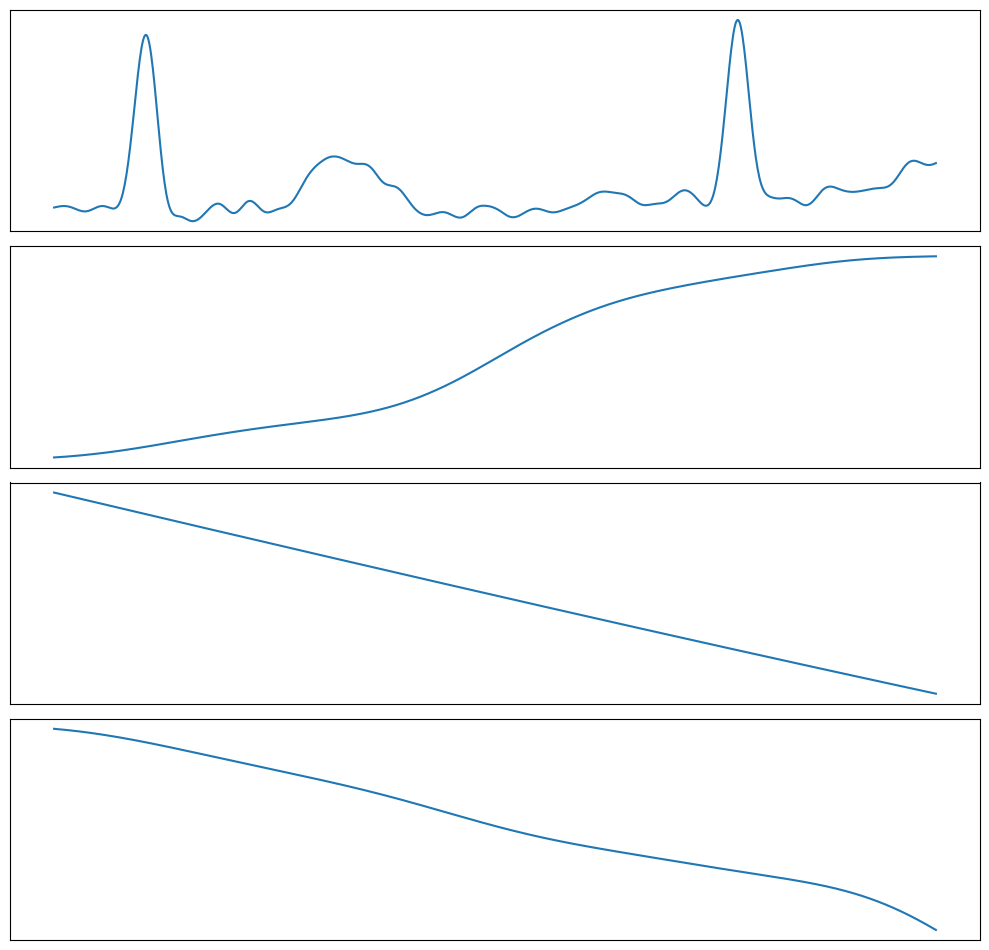

In [10]:
# Plot the Original Signals
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
# fig.suptitle("Original Signals")
for i in range(4):
    axs[i].plot(X[0, :, i])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
X_train, X_test = train_test_split(X, test_size=0.3)
X_test, X_val = train_test_split(X_test, test_size=0.5)

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

In [13]:

# Wrap the data in a DataLoader
batch_size = 4

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size, shuffle=False)

In [14]:
# Initialize the model, loss function, and optimizer
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 300

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        
        # Get the batch and reshape it for Conv1d (batch, channels, sequence_length)
        batch = X_train_tensor[i : i + batch_size].permute(0, 2, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch)

        # Calculate loss
        loss = criterion(outputs, batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(X_train_tensor):.4f}")

# Validation
model.eval()
with torch.no_grad():
    val_batch = X_val_tensor.permute(0, 2, 1)
    val_outputs = model(val_batch)
    val_loss = criterion(val_outputs, val_batch)
    print(f"Validation Loss: {val_loss.item()}")

torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 32, 19])
torch.Size([4, 1, 1000])
torch.Size([4, 8, 99])
torch.Size([4, 3

KeyboardInterrupt: 

In [ ]:
input_observations = X_test_tensor[0]

In [ ]:
input_observations.shape

In [ ]:
# Encode the observations
driving_observations = input_observations
driving_observations = driving_observations.permute(1, 0).unsqueeze(0)
latent_space = model.encode(driving_observations)
driving_observations = latent_space.squeeze(0)

In [ ]:
# reduce the latent space from 2 to 1 dimension using PCA
pca = PCA(n_components=1)
pca.fit(driving_observations.cpu().detach().numpy())
driving_observations = pca.transform(driving_observations.cpu().detach().numpy()).squeeze()
driving_observations.shape

In [ ]:
output = model.decode(latent_space).squeeze(0).permute(1, 0)
output.shape

In [ ]:
# add the reconstruction error to the observations
driving_observations_error = torch.nn.functional.mse_loss(output,input_observations,)
driving_observations_error

In [ ]:
# add error to the observations
driving_observations = np.concatenate((driving_observations, [driving_observations_error.item()]))
driving_observations.shape

In [ ]:
# Switch model to evaluation mode
model.eval()

# Prepare the test data for inference (permute to match Conv1d input shape)
test_batch = X_test_tensor.permute(0, 2, 1)

# Generate the reconstructed outputs
with torch.no_grad():
    reconstructed = model(test_batch).permute(0, 2, 1)  # Permute back to original shape for comparison

# Convert tensors to numpy arrays for plotting
original_signals = X_test_tensor.cpu().numpy()
reconstructed_signals = reconstructed.cpu().numpy()

# Plot the original and reconstructed signals for a sample
sample_idx = random.randint(0, len(X_test_tensor))
time_steps = range(original_signals.shape[1])


In [ ]:
# Plot each signal type
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
signal_names = ["ECG_Clean", "RSP_Clean", "EDA_Tonic", "EDA_Phasic"]

for i in range(4):
    axes[i].plot(time_steps[10:-10], original_signals[sample_idx, 10:-10, i], label="Original", alpha=0.7, color="blue")
    axes[i].set_ylabel(signal_names[i])
    axes[i].legend()

axes[3].set_xlabel("Time Steps")
plt.show()

# Plot each signal type
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
signal_names = ["ECG_Clean", "RSP_Clean", "EDA_Tonic", "EDA_Phasic"]

for i in range(4):
    axes[i].plot(
        time_steps[10:-10],
        reconstructed_signals[sample_idx, 10:-10, i],
        label="Reconstructed",
        linestyle="--",
        alpha=0.7,
        color="red",
    )
    axes[i].set_ylabel(signal_names[i])
    axes[i].legend()

axes[3].set_xlabel("Time Steps")
plt.show()

In [ ]:
# plot input ECG signal and the reconstructed ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time_steps[0:1000], original_signals[sample_idx, 0:1000, 0], label="Original", alpha=0.7)
plt.show()

# plot input ECG signal and the reconstructed ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time_steps[0:1000], reconstructed_signals[sample_idx, 0:1000, 0], label="Reconstructed", alpha=0.7, color='orange')
plt.show()

In [ ]:
# plot input ECG signal and the reconstructed ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time_steps[0:1000], original_signals[sample_idx, 0:1000, 1], label="Original", alpha=0.7)
plt.show()

# plot input ECG signal and the reconstructed ECG signal
plt.figure(figsize=(12, 6))
plt.plot(
    time_steps[0:1000],
    reconstructed_signals[sample_idx, 0:1000, 1],
    label="Reconstructed",
    alpha=0.7,
    color="orange",
)
plt.show()

In [ ]:
# plot input ECG signal and the reconstructed ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time_steps[0:1000], original_signals[sample_idx, 0:1000, 2], label="Original", alpha=0.7)
plt.show()

# plot input ECG signal and the reconstructed ECG signal
plt.figure(figsize=(12, 6))
plt.plot(
    time_steps[0:1000],
    reconstructed_signals[sample_idx, 0:1000, 2],
    label="Reconstructed",
    alpha=0.7,
    color="orange",
)
plt.show()

In [ ]:
# plot input ECG signal and the reconstructed ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time_steps[0:1000], original_signals[sample_idx, 0:1000, 3], label="Original", alpha=0.7)
plt.show()

# plot input ECG signal and the reconstructed ECG signal
plt.figure(figsize=(12, 6))
plt.plot(
    time_steps[0:1000],
    reconstructed_signals[sample_idx, 0:1000, 3],
    label="Reconstructed",
    alpha=0.7,
    color="orange",
)
plt.show()

In [ ]:
# overlay the input and reconstructed ECG signals
plt.figure(figsize=(12, 6))
plt.plot(time_steps[0:1000], original_signals[sample_idx, 0:1000, 0], label="Original", alpha=0.7)
plt.plot(time_steps[0:1000], reconstructed_signals[sample_idx, 0:1000, 0], label="Reconstructed", alpha=0.7)
plt.legend()
plt.show()

In [ ]:
# Example: Visualizing ECG features after each layer
ecg = torch.tensor(original_signals[:, 0, :], dtype=torch.float32).unsqueeze(1).to(device)  # Extract ECG signal
ecg_after_first_conv = model.ecg_encoder[0](ecg)  # Apply first Conv1d
ecg_after_second_conv = model.ecg_encoder(ecg)  # Full encoder

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(ecg[0, 0].cpu().detach().numpy())
plt.title("Raw ECG Signal")
plt.subplot(1, 3, 2)
plt.imshow(ecg_after_first_conv[0].cpu().detach().numpy(), aspect="auto", cmap="viridis")
plt.title("After First Conv1d")
plt.subplot(1, 3, 3)
plt.imshow(ecg_after_second_conv[0].cpu().detach().numpy(), aspect="auto", cmap="viridis")
plt.title("After Second Conv1d")
plt.show()